# Multi Output LSTM

In [2]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd
import torch 

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload 
%autoreload 2

# Data

In [82]:
run_dir = Path("/datadrive/data/runs/multi_output_sm_discharge_spec_1406_121319")
run_dir = Path("/datadrive/data/runs/discharge_to_ERA5Land_SoilMoisture_1008_181921")

# GET config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

# GET preds
res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)

# GET trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg)

100%|██████████| 668/668 [00:00<00:00, 1215.04it/s]


Using the model weights from /datadrive/data/runs/discharge_to_ERA5Land_SoilMoisture_1008_181921/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(23, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=4, bias=True)
    )
  )
)

In [83]:
list(preds.data_vars)

['swvl1_obs',
 'swvl1_sim',
 'swvl2_obs',
 'swvl2_sim',
 'swvl3_obs',
 'swvl3_sim',
 'swvl4_obs',
 'swvl4_sim']

In [88]:
target_vars = np.unique(["_".join(v.split("_")[:-1]) for v in list(preds.data_vars)])
print(f"{len(target_vars)} Variables: {target_vars}")

if not "errors" in globals().keys():
    all_errors = []
    for variable in target_vars:
        sm_errors = calculate_all_error_metrics(
            preds,
            basin_coord="station_id",
            time_coord="date",
            obs_var=f"{variable}_obs",
            sim_var=f"{variable}_sim",
            metrics=["NSE", "Pearson-r"],
        )
        sm_errors = sm_errors.assign_coords({"member": [variable]})
        all_errors.append(sm_errors)

    errors = xr.concat(all_errors, dim="member")

Calculating Errors:   1%|          | 4/668 [00:00<00:17, 38.33it/s, 101005]

4 Variables


Calculating Errors: 100%|██████████| 668/668 [00:13<00:00, 50.34it/s, 97002]


### CAMELS GB

In [85]:
from scripts.cell_state.normalize import normalize_xr_by_basin

ds = xr.open_dataset(Path("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc"))

In [86]:
# unq_vars = np.unique(["_".join(v.split("_")[0:-1]) for v in preds.data_vars])
from scripts.cell_state.analysis import finite_flat, histogram_plot

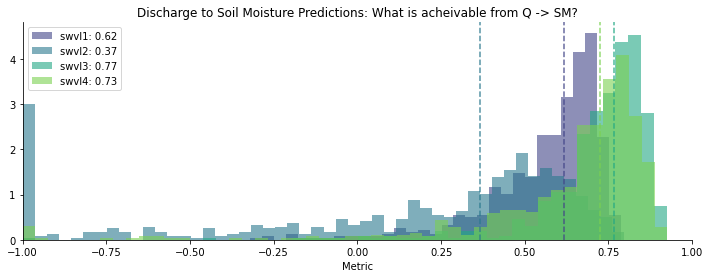

In [87]:
f, ax = plt.subplots(1, 1, figsize=(12, 4))


colors = sns.color_palette("viridis", 4)
for ix, target_var in enumerate(errors.member.values):
    arr = finite_flat(errors["NSE"].sel(member=target_var))
    med = np.median(arr)
    histogram_plot(np.clip(arr, -1, 1), hist_kwargs={"color": colors[ix], "label": f"{target_var}: {med:.2f}"}, ax=ax)
ax.set_title("Discharge to Soil Moisture Predictions: What is acheivable from Q -> SM?")
ax.set_xlim(-1, 1)
ax.legend()

# Timeseries

In [ ]:
px = np.random.choice(preds.station_id.values, 1)[0]

times = slice("04-01-2007", "01-01-2008")

f, axs = plt.subplots(4, 1, figsize=(12, 2*4), sharex=True)

for ix, member in enumerate(errors.member.values):
    ax = axs[ix]
    nse = float(errors.sel(station_id=px, member=member)["NSE"])
    preds[f"{member}_obs"].sel(station_id=px, date=times).plot(ax=ax, color="k", alpha=0.8, ls="--", label=f"{member} Obs")
    preds[f"{member}_sim"].sel(station_id=px, date=times).plot(ax=ax, label=f"{member} Forecast", color=colors[ix])
    ax.set_title(f"Station {px} {member} NSE: {nse:.2f}")

plt.tight_layout()